In [ ]:
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_PROJECT"] = ""

## Install Dependencies

In [2]:
# pip install langgraph langchain langchain-ollama langchain-core sentence-transformers faiss-cpu numpy rank_bm25

## Load Conversation Dataset

In [2]:
import json
locomo10_path = "data/locomo/locomo10.json"
with open(locomo10_path, "r") as f:
    locomo10 = json.load(f)

In [3]:
def get_conversation_text(conversation):
    text = ""
    for key in conversation:
        if key.startswith("session_") and not key.endswith("_time"):
            session = conversation[key]
            for msg_dict in session:
                role = msg_dict['text']
                text += role + "\n"
    return text

conversation = get_conversation_text(locomo10[0]['conversation'])
queries = locomo10[0]['qa']
print(f"Conversation length: {len(conversation)} characters")
print(f"Number of questions: {len(queries)}")

Conversation length: 58109 characters
Number of questions: 199


## Playbook Data Structures

In [4]:
import uuid
from dataclasses import dataclass, field
from typing import List, Dict, Any
import numpy as np

@dataclass
class Bullet:
    """Represents a bullet in the playbook with metadata"""
    id: str = field(default_factory=lambda: str(uuid.uuid4()))
    content: str = ""
    helpful_count: int = 0
    harmful_count: int = 0
    
    def mark_helpful(self):
        self.helpful_count += 1
    
    def mark_harmful(self):
        self.harmful_count += 1
    
    def to_dict(self):
        return {
            'id': self.id,
            'content': self.content,
            'helpful_count': self.helpful_count,
            'harmful_count': self.harmful_count
        }
    
    def __str__(self):
        return f"[ID: {self.id[:8]}] {self.content} (✓{self.helpful_count}/✗{self.harmful_count})"

class Playbook:
    """Manages the collection of bullets, user profiles, and memories/events"""
    def __init__(self):
        self.bullets: List[Bullet] = []
        self.user_profiles: Dict[str, Any] = {}
        self.memories_events: List[Dict[str, Any]] = []
    
    def add_bullet(self, bullet: Bullet):
        self.bullets.append(bullet)
    
    def update_bullet(self, index: int, new_content: str):
        if 0 <= index < len(self.bullets):
            self.bullets[index].content = new_content
            return True
        return False
    
    def remove_bullet(self, index: int):
        if 0 <= index < len(self.bullets):
            self.bullets.pop(index)
            return True
        return False
    
    def modify_user_profile(self, user_id: str, profile_data: Dict[str, Any]):
        if user_id in self.user_profiles:
            self.user_profiles[user_id].update(profile_data)
        else:
            self.user_profiles[user_id] = profile_data
    
    def add_memory_event(self, event_data: Dict[str, Any]):
        self.memories_events.append(event_data)
    
    def update_memory_event(self, index: int, new_event_data: Dict[str, Any]):
        if 0 <= index < len(self.memories_events):
            self.memories_events[index] = new_event_data
            return True
        return False
    
    def format_for_prompt(self) -> str:
        if not self.bullets and not self.user_profiles and not self.memories_events:
            return "No previous knowledge available"
        
        formatted_output = []
        
        if self.bullets:
            formatted_output.append("Knowledge Bullets:")
            for i, bullet in enumerate(self.bullets):
                formatted_output.append(f"{i}. {bullet}")
        
        if self.user_profiles:
            formatted_output.append("\nUser Profiles:")
            for user_id, profile in self.user_profiles.items():
                formatted_output.append(f"User {user_id}: {profile}")
        
        if self.memories_events:
            formatted_output.append("\nMemories and Events:")
            for i, event in enumerate(self.memories_events):
                formatted_output.append(f"{i}. {event}")
        
        return "\n".join(formatted_output)
    
    def __len__(self):
        return len(self.bullets)

## Retrieval Engine

In [5]:
from sentence_transformers import SentenceTransformer
import faiss
from typing import List, Tuple

class ConversationRetriever:
    """Retrieval engine for finding relevant conversation chunks"""
    
    def __init__(self, model_name: str = 'all-MiniLM-L6-v2', chunk_size: int = 500):
        self.model = SentenceTransformer(model_name)
        self.chunk_size = chunk_size
        self.chunks: List[str] = []
        self.embeddings: np.ndarray = None
        self.index = None
        
    def chunk_conversation(self, conversation_text: str, overlap: int = 50) -> List[str]:
        chunks = []
        start = 0
        text_len = len(conversation_text)
        
        while start < text_len:
            end = min(start + self.chunk_size, text_len)
            chunk = conversation_text[start:end]
            
            if end < text_len:
                last_period = chunk.rfind('.')
                last_newline = chunk.rfind('\n')
                break_point = max(last_period, last_newline)
                
                if break_point > self.chunk_size * 0.5:
                    chunk = chunk[:break_point + 1]
                    end = start + break_point + 1
            
            chunks.append(chunk.strip())
            start = end - overlap if end < text_len else end
            
        return chunks
    
    def embed_conversation(self, conversation_text: str):
        print(f"Chunking conversation with chunk_size={self.chunk_size}...")
        self.chunks = self.chunk_conversation(conversation_text)
        print(f"Created {len(self.chunks)} chunks")
        
        print("Embedding chunks...")
        self.embeddings = self.model.encode(self.chunks, show_progress_bar=True)
        
        print("Building FAISS index...")
        dimension = self.embeddings.shape[1]
        self.index = faiss.IndexFlatL2(dimension)
        self.index.add(self.embeddings.astype('float32'))
        
        print(f"✓ Retrieval engine ready with {len(self.chunks)} chunks")
    
    def get_context(self, query: str, top_k: int = 3, separator: str = "\n\n---\n\n") -> str:
        if self.index is None:
            raise ValueError("No conversation embedded. Call embed_conversation() first.")
        
        query_embedding = self.model.encode([query])
        distances, indices = self.index.search(query_embedding.astype('float32'), top_k)
        
        chunks = [self.chunks[idx] for idx in indices[0] if idx < len(self.chunks)]
        return separator.join(chunks)

# Initialize global retriever
retriever = ConversationRetriever(chunk_size=500)
retriever.embed_conversation(conversation)

/home/spike/miniforge3/envs/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Chunking conversation with chunk_size=500...
Created 141 chunks
Embedding chunks...


Batches: 100%|██████████| 5/5 [00:00<00:00, 21.91it/s]

Building FAISS index...
✓ Retrieval engine ready with 141 chunks


## LLM Setup

In [6]:
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatOllama(
    model="gemma3:27b-it-qat",
    temperature=0.1,
)

## Prompts

### English

In [7]:
# Generator Prompt
generator_prompt = """
I am your supervisor and you are a super intelligent AI Assistant whose job is to achieve my day-to-day tasks completely autonomously.
You will be given a cheatsheet containing relevant strategies, patterns, and examples from similar problems to apply and solve the
current task.
Cheatsheet:
{playbook_text}

Context of the Conversation:
{context}

Instructions:
1. ANALYSIS & STRATEGY
Carefully analyze both the question and cheatsheet before starting
Search for and identify any applicable patterns, strategies, or examples within the cheatsheet
Create a structured approach to solving the problem at hand
Review and document any limitations in the provided reference materials
2. SOLUTION DEVELOPMENT
Present your solution using clear, logical steps that others can follow and review
Explain your reasoning and methodology before presenting final conclusions
Provide detailed explanations for each step of the process
Check and verify all assumptions and intermediate calculations


Answer: [your answer here]
Reasoning: [your detailed reasoning here]
Key Insights: [list of key insights derived from the cheatsheet and context]
"""

# Reflector Prompt
reflector_prompt = """ You are an expert in extracting insights from conversation interactions.
Context of the Conversation:
{context}
Generated Answer: {generated_answer}
Current Playbook:
{playbook_text}
Analyze the generated answer and reasoning process and identify from a global perspective:
1. Strategies that worked well in generating the answer
2. Important domain concepts that were helpful
3. Patterns in the context that aided in answering
4. Knowledge that would be useful for similar future questions
Also, identify the user profile information:
1. Relevant user preferences or traits revealed in the conversation
2. Behavioral patterns that could inform future interactions
3. Any specific needs or goals indicated by the user
Finally, extract any memories or events from the conversation that could be relevant to improving the playbook

Write the 3 sections in the following format:
INSIGHTS:
1. [insight 1]
2. [insight 2]
...

USER_PROFILE:
1. [profile item 1]
2. [profile item 2]
...

MEMORIES_EVENTS:
1. [memory/event 1]
2. [memory/event 2]
...
"""

# Insights Curator Prompt
insights_curator_prompt = """You are an insights knowledge curator. Your task is to evaluate insights and decide what to add, update, or remove from the playbook's knowledge bullets.

Current Playbook Bullets:
{playbook_bullets}

Original Question: {query}
Generated Answer: {generated_answer}

Proposed Insights:
{insights_text}

Evaluate each insight carefully and decide:
1. Whether the insight should be ADDED as a new bullet (is it useful, relevant, and non-redundant)
2. Whether the insight should UPDATE an existing bullet (if it refines or corrects existing knowledge)
3. Whether existing bullets should be REMOVED (if they are outdated or incorrect)

IMPORTANT: Avoid redundancy! If a new insight is similar to an existing bullet, prefer to UPDATE the existing one rather than adding a duplicate.

Answer in the format:
ADD_INSIGHTS: [list the numbers of insights to add as new bullets, separated by commas, or 'none']
UPDATE_INSIGHTS: [format: "insight_number->bullet_index" to update existing bullet, separated by commas, or 'none']
REMOVE_BULLETS: [list the bullet indices to remove, separated by commas, or 'none']
REASON: [brief explanation of your decisions, especially for updates and removals]
"""

# User Profile Curator Prompt
user_profile_curator_prompt = """You are a user profile curator. Your task is to evaluate user profile information and decide what to add or update in the playbook.

Current User Profiles:
{user_profiles}

Original Question: {query}
Generated Answer: {generated_answer}

Proposed User Profile Items:
{user_profile_text}

Evaluate each user profile item carefully and decide:
1. Whether the item should be ADDED as new user profile information
2. Whether the item should UPDATE existing user profile information

Answer in the format:
ADD_USER_PROFILE: [list the numbers of user profile items to add, separated by commas, or 'none']
UPDATE_USER_PROFILE: [list the numbers of user profile items to update, separated by commas, or 'none']
REASON: [brief explanation of your decisions]
"""

# Memories Curator Prompt
memories_curator_prompt = """You are a memories and events curator. Your task is to evaluate memories and events extracted from conversations and decide what to add or update in the playbook.

Current Memories and Events:
{memories_events}

Original Question: {query}
Generated Answer: {generated_answer}

Proposed Memories/Events:
{memories_events_text}

Evaluate each memory/event carefully and decide:
1. Whether the memory/event should be ADDED as new information
2. Whether the memory/event should UPDATE existing memory/event information

Answer in the format:
ADD_MEMORIES_EVENTS: [list the numbers of memories/events to add, separated by commas, or 'none']
UPDATE_MEMORIES_EVENTS: [format: "memory_number->event_index" to update existing event, separated by commas, or 'none']
REASON: [brief explanation of your decisions]
"""

### Portuguese

In [8]:
# Generator Prompt - Portuguese
generator_prompt = """
Eu sou seu supervisor e você é um Assistente de IA super inteligente cujo trabalho é realizar minhas tarefas do dia a dia de forma completamente autônoma.
Você receberá uma folha de dicas contendo estratégias relevantes, padrões e exemplos de problemas similares para aplicar e resolver a
tarefa atual.
Playbook:
{playbook_text}

Contexto da Conversa:
{context}

Instruções:
1. ANÁLISE & ESTRATÉGIA
Analise cuidadosamente tanto a pergunta quanto a folha de dicas antes de começar
Busque e identifique quaisquer padrões, estratégias ou exemplos aplicáveis dentro da folha de dicas
Crie uma abordagem estruturada para resolver o problema em questão
Revise e documente quaisquer limitações nos materiais de referência fornecidos
2. DESENVOLVIMENTO DA SOLUÇÃO
Apresente sua solução usando passos claros e lógicos que outros possam seguir e revisar
Explique seu raciocínio e metodologia antes de apresentar conclusões finais
Forneça explicações detalhadas para cada etapa do processo
Verifique e valide todas as suposições e cálculos intermediários


Resposta: [sua resposta aqui]
Raciocínio: [seu raciocínio detalhado aqui]
Insights Chave: [lista de insights chave derivados da folha de dicas e contexto]
"""

# Reflector Prompt - Portuguese
reflector_prompt = """Você é um especialista em extrair insights de interações de conversa.
Contexto da Conversa:
{context}
Resposta Gerada: {generated_answer}
Playbook Atual:
{playbook_text}
Analise a resposta gerada e o processo de raciocínio e identifique de uma perspectiva global:
1. Estratégias que funcionaram bem na geração da resposta
2. Conceitos de domínio importantes que foram úteis
3. Padrões no contexto que auxiliaram na resposta
4. Conhecimento que seria útil para perguntas futuras similares
Além disso, identifique as informações do perfil do usuário:
1. Preferências ou características relevantes do usuário reveladas na conversa
2. Padrões comportamentais que poderiam informar interações futuras
3. Quaisquer necessidades ou objetivos específicos indicados pelo usuário
Finalmente, extraia quaisquer memórias ou eventos da conversa que possam ser relevantes para melhorar o playbook

Escreva as 3 seções no seguinte formato:
INSIGHTS:
1. [insight 1]
2. [insight 2]
...

USER_PROFILE:
1. [item do perfil 1]
2. [item do perfil 2]
...

MEMORIES_EVENTS:
1. [memória/evento 1]
2. [memória/evento 2]
...
"""

# Insights Curator Prompt - Portuguese
insights_curator_prompt = """Você é um curador de conhecimento de insights. Sua tarefa é avaliar insights e decidir o que adicionar, atualizar ou remover dos bullets de conhecimento do playbook.

Bullets Atuais do Playbook:
{playbook_bullets}

Pergunta Original: {query}
Resposta Gerada: {generated_answer}

Insights Propostos:
{insights_text}

Avalie cada insight cuidadosamente e decida:
1. Se o insight deve ser ADICIONADO como um novo bullet (é útil, relevante e não redundante)
2. Se o insight deve ATUALIZAR um bullet existente (se refina ou corrige conhecimento existente)
3. Se bullets existentes devem ser REMOVIDOS (se estão desatualizados ou incorretos)

IMPORTANTE: Evite redundância! Se um novo insight é similar a um bullet existente, prefira ATUALIZAR o existente em vez de adicionar um duplicado.

Responda no formato:
ADD_INSIGHTS: [liste os números dos insights a adicionar como novos bullets, separados por vírgulas, ou 'none']
UPDATE_INSIGHTS: [formato: "número_insight->índice_bullet" para atualizar bullet existente, separados por vírgulas, ou 'none']
REMOVE_BULLETS: [liste os índices dos bullets a remover, separados por vírgulas, ou 'none']
REASON: [breve explicação de suas decisões, especialmente para atualizações e remoções]
"""

# User Profile Curator Prompt - Portuguese
user_profile_curator_prompt = """Você é um curador de perfis de usuário. Sua tarefa é avaliar informações de perfil de usuário e decidir o que adicionar ou atualizar no playbook.

Perfis de Usuário Atuais:
{user_profiles}

Pergunta Original: {query}
Resposta Gerada: {generated_answer}

Itens de Perfil de Usuário Propostos:
{user_profile_text}

Avalie cada item de perfil de usuário cuidadosamente e decida:
1. Se o item deve ser ADICIONADO como nova informação de perfil de usuário
2. Se o item deve ATUALIZAR informações existentes de perfil de usuário

Responda no formato:
ADD_USER_PROFILE: [liste os números dos itens de perfil de usuário a adicionar, separados por vírgulas, ou 'none']
UPDATE_USER_PROFILE: [liste os números dos itens de perfil de usuário a atualizar, separados por vírgulas, ou 'none']
REASON: [breve explicação de suas decisões]
"""

# Memories Curator Prompt - Portuguese
memories_curator_prompt = """Você é um curador de memórias e eventos. Sua tarefa é avaliar memórias e eventos extraídos de conversas e decidir o que adicionar ou atualizar no playbook.

Memórias e Eventos Atuais:
{memories_events}

Pergunta Original: {query}
Resposta Gerada: {generated_answer}

Memórias/Eventos Propostos:
{memories_events_text}

Avalie cada memória/evento cuidadosamente e decida:
1. Se a memória/evento deve ser ADICIONADA como nova informação
2. Se a memória/evento deve ATUALIZAR informações existentes de memória/evento

Responda no formato:
ADD_MEMORIES_EVENTS: [liste os números das memórias/eventos a adicionar, separados por vírgulas, ou 'none']
UPDATE_MEMORIES_EVENTS: [formato: "memory_number->event_index" para atualizar evento existente, separados por vírgulas, ou 'none']
REASON: [breve explicação de suas decisões]
"""

## LangGraph State Definition

In [9]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END
import operator

class ACEState(TypedDict):
    """State for the ACE workflow"""
    # Input
    question: str
    playbook: Playbook
    top_k: int
    
    # Retrieved context
    context: str
    
    # Generator output
    generated_answer: str
    
    # Reflector output
    reflector_answer: str
    sections: Dict[str, List[str]]
    
    # Curator outputs
    insights_curator_answer: str
    user_profile_curator_answer: str
    memories_curator_answer: str
    curator_answer: str
    
    # Parsed actions
    actions: Dict[str, Any]
    
    # Tracking
    messages: Annotated[List[str], operator.add]

## Graph Nodes

In [10]:
import re

def retrieve_context_node(state: ACEState) -> ACEState:
    """Node: Retrieve relevant conversation context"""
    context = retriever.get_context(state["question"], top_k=state["top_k"])
    state["context"] = context
    state["messages"].append(f"✓ Retrieved context ({len(context)} chars)")
    return state

def generate_answer_node(state: ACEState) -> ACEState:
    """Node: Generate answer using current playbook"""
    template = ChatPromptTemplate([
        ("system", generator_prompt),
        ("user", "{query}"),
    ])
    
    chain = template | llm | StrOutputParser()
    
    answer = chain.invoke({
        "playbook_text": state["playbook"].format_for_prompt(),
        "context": state["context"],
        "query": state["question"],
    })
    
    state["generated_answer"] = f"Question: {state['question']}\n\n{answer}"
    state["messages"].append(f"✓ Generated answer ({len(answer)} chars)")
    return state

def reflect_on_answer_node(state: ACEState) -> ACEState:
    """Node: Reflect on the generated answer"""
    template = ChatPromptTemplate([
        ("system", reflector_prompt),
        ("user", "{query}"),
    ])
    
    chain = template | llm | StrOutputParser()
    
    reflector_output = chain.invoke({
        "playbook_text": state["playbook"].format_for_prompt(),
        "context": state["context"],
        "generated_answer": state["generated_answer"],
        "query": "Extract useful insights to improve the playbook.",
    })
    
    state["reflector_answer"] = reflector_output
    state["messages"].append("✓ Reflection complete")
    return state

def parse_sections_node(state: ACEState) -> ACEState:
    """Node: Parse reflector output into sections"""
    sections = {"INSIGHTS": [], "USER_PROFILE": [], "MEMORIES_EVENTS": []}
    current_section = None
    
    for line in state["reflector_answer"].splitlines():
        line_stripped = line.strip()
        line_upper = line_stripped.upper()
        
        if "INSIGHT" in line_upper and ":" in line_stripped:
            current_section = "INSIGHTS"
            continue
        elif "USER" in line_upper and "PROFILE" in line_upper and ":" in line_stripped:
            current_section = "USER_PROFILE"
            continue
        elif "MEMOR" in line_upper and "EVENT" in line_upper and ":" in line_stripped:
            current_section = "MEMORIES_EVENTS"
            continue
        
        if line_stripped and current_section:
            clean_line = re.sub(r'^[\d\-\*]+[\.\)]\s*', '', line_stripped).strip()
            if clean_line and not clean_line.endswith(':'):
                sections[current_section].append(clean_line)
    
    state["sections"] = sections
    state["messages"].append(
        f"✓ Parsed sections: {len(sections['INSIGHTS'])} insights, "
        f"{len(sections['USER_PROFILE'])} profiles, {len(sections['MEMORIES_EVENTS'])} events"
    )
    return state

def run_curators_node(state: ACEState) -> ACEState:
    """Node: Run all three curators"""
    def format_section_list(items, section_name):
        if not items:
            return f"No {section_name} available."
        return "\n".join([f"{i+1}. {item}" for i, item in enumerate(items)])
    
    sections = state["sections"]
    playbook = state["playbook"]
    
    # Insights curator
    insights_template = ChatPromptTemplate([("system", insights_curator_prompt), ("user", "{query}")])
    insights_chain = insights_template | llm | StrOutputParser()
    
    insights_answer = insights_chain.invoke({
        "playbook_bullets": "\n".join([f"{i}. {bullet}" for i, bullet in enumerate(playbook.bullets)]) if playbook.bullets else "No bullets yet.",
        "query": state["question"],
        "generated_answer": state["generated_answer"],
        "insights_text": format_section_list(sections["INSIGHTS"], "insights"),
    })
    
    # User profile curator
    profile_template = ChatPromptTemplate([("system", user_profile_curator_prompt), ("user", "{query}")])
    profile_chain = profile_template | llm | StrOutputParser()
    
    profile_answer = profile_chain.invoke({
        "user_profiles": str(playbook.user_profiles) if playbook.user_profiles else "No user profiles yet.",
        "query": state["question"],
        "generated_answer": state["generated_answer"],
        "user_profile_text": format_section_list(sections["USER_PROFILE"], "user profile items"),
    })
    
    # Memories curator
    memories_template = ChatPromptTemplate([("system", memories_curator_prompt), ("user", "{query}")])
    memories_chain = memories_template | llm | StrOutputParser()
    
    memories_answer = memories_chain.invoke({
        "memories_events": "\n".join([f"{i}. {event}" for i, event in enumerate(playbook.memories_events)]) if playbook.memories_events else "No memories/events yet.",
        "query": state["question"],
        "generated_answer": state["generated_answer"],
        "memories_events_text": format_section_list(sections["MEMORIES_EVENTS"], "memories/events"),
    })
    
    state["insights_curator_answer"] = insights_answer
    state["user_profile_curator_answer"] = profile_answer
    state["memories_curator_answer"] = memories_answer
    state["curator_answer"] = f"{insights_answer}\n{profile_answer}\n{memories_answer}"
    state["messages"].append("✓ All curators completed")
    return state

def parse_actions_node(state: ACEState) -> ACEState:
    """Node: Parse curator actions"""
    actions = {
        'insights_to_add': [],
        'insights_to_update': {},
        'bullets_to_remove': [],
        'user_profiles_to_add': [],
        'user_profiles_to_update': [],
        'memories_events_to_add': [],
        'memories_events_to_update': {}
    }
    
    for line in state["curator_answer"].splitlines():
        line = line.strip()
        
        if line.startswith("ADD_INSIGHTS:"):
            add_part = line[len("ADD_INSIGHTS:"):].strip()
            if add_part.lower() != "none":
                actions['insights_to_add'] = [int(x.strip()) for x in add_part.split(",") if x.strip().isdigit()]
        
        elif line.startswith("UPDATE_INSIGHTS:"):
            update_part = line[len("UPDATE_INSIGHTS:"):].strip()
            if update_part.lower() != "none":
                for item in update_part.split(","):
                    if "->" in item:
                        parts = item.split("->")
                        if len(parts) == 2 and parts[0].strip().isdigit() and parts[1].strip().isdigit():
                            actions['insights_to_update'][int(parts[0].strip())] = int(parts[1].strip())
        
        elif line.startswith("REMOVE_BULLETS:"):
            remove_part = line[len("REMOVE_BULLETS:"):].strip()
            if remove_part.lower() != "none":
                actions['bullets_to_remove'] = [int(x.strip()) for x in remove_part.split(",") if x.strip().isdigit()]
        
        elif line.startswith("ADD_USER_PROFILE:"):
            add_part = line[len("ADD_USER_PROFILE:"):].strip()
            if add_part.lower() != "none":
                actions['user_profiles_to_add'] = [int(x.strip()) for x in add_part.split(",") if x.strip().isdigit()]
        
        elif line.startswith("UPDATE_USER_PROFILE:"):
            update_part = line[len("UPDATE_USER_PROFILE:"):].strip()
            if update_part.lower() != "none":
                actions['user_profiles_to_update'] = [int(x.strip()) for x in update_part.split(",") if x.strip().isdigit()]
        
        elif line.startswith("ADD_MEMORIES_EVENTS:"):
            add_part = line[len("ADD_MEMORIES_EVENTS:"):].strip()
            if add_part.lower() != "none":
                actions['memories_events_to_add'] = [int(x.strip()) for x in add_part.split(",") if x.strip().isdigit()]
        
        elif line.startswith("UPDATE_MEMORIES_EVENTS:"):
            update_part = line[len("UPDATE_MEMORIES_EVENTS:"):].strip()
            if update_part.lower() != "none":
                for item in update_part.split(","):
                    if "->" in item:
                        parts = item.split("->")
                        if len(parts) == 2 and parts[0].strip().isdigit() and parts[1].strip().isdigit():
                            actions['memories_events_to_update'][int(parts[0].strip())] = int(parts[1].strip())
    
    state["actions"] = actions
    state["messages"].append(f"✓ Parsed actions")
    return state

def update_playbook_node(state: ACEState) -> ACEState:
    """Node: Update the playbook based on curator decisions"""
    playbook = state["playbook"]
    sections = state["sections"]
    actions = state["actions"]
    
    updates_count = 0
    
    # Remove bullets
    for idx in sorted(actions['bullets_to_remove'], reverse=True):
        if playbook.remove_bullet(idx):
            updates_count += 1
    
    # Update bullets
    for insight_idx, bullet_idx in actions['insights_to_update'].items():
        if 0 <= insight_idx - 1 < len(sections["INSIGHTS"]):
            insight_content = sections["INSIGHTS"][insight_idx - 1]
            if playbook.update_bullet(bullet_idx, insight_content):
                updates_count += 1
    
    # Add bullets
    for idx in actions['insights_to_add']:
        if 0 <= idx - 1 < len(sections["INSIGHTS"]):
            insight_content = sections["INSIGHTS"][idx - 1]
            new_bullet = Bullet(content=insight_content)
            playbook.add_bullet(new_bullet)
            updates_count += 1
    
    # Add user profiles
    for idx in actions['user_profiles_to_add']:
        if 0 <= idx - 1 < len(sections["USER_PROFILE"]):
            profile_content = sections["USER_PROFILE"][idx - 1]
            playbook.modify_user_profile("default_user", {f"item_{idx}": profile_content})
            updates_count += 1
    
    # Update user profiles
    for idx in actions['user_profiles_to_update']:
        if 0 <= idx - 1 < len(sections["USER_PROFILE"]):
            profile_content = sections["USER_PROFILE"][idx - 1]
            playbook.modify_user_profile("default_user", {f"item_{idx}": profile_content})
            updates_count += 1
    
    # Update memories
    for insight_idx, event_idx in actions['memories_events_to_update'].items():
        if 0 <= insight_idx - 1 < len(sections["MEMORIES_EVENTS"]):
            event_content = sections["MEMORIES_EVENTS"][insight_idx - 1]
            if playbook.update_memory_event(event_idx, {"event": event_content}):
                updates_count += 1
    
    # Add memories
    for idx in actions['memories_events_to_add']:
        if 0 <= idx - 1 < len(sections["MEMORIES_EVENTS"]):
            event_content = sections["MEMORIES_EVENTS"][idx - 1]
            playbook.add_memory_event({"event": event_content})
            updates_count += 1
    
    state["messages"].append(
        f"✓ Updated playbook: {len(playbook)} bullets, "
        f"{len(playbook.user_profiles)} profiles, {len(playbook.memories_events)} events"
    )
    return state

## Build LangGraph Workflow

In [11]:
from langgraph.graph import StateGraph, START, END

# Create the graph
workflow = StateGraph(ACEState)

# Add nodes
workflow.add_node("retrieve_context", retrieve_context_node)
workflow.add_node("generate_answer", generate_answer_node)
workflow.add_node("reflect", reflect_on_answer_node)
workflow.add_node("parse_sections", parse_sections_node)
workflow.add_node("run_curators", run_curators_node)
workflow.add_node("parse_actions", parse_actions_node)
workflow.add_node("update_playbook", update_playbook_node)

# Add edges
workflow.add_edge(START, "retrieve_context")
workflow.add_edge("retrieve_context", "generate_answer")
workflow.add_edge("generate_answer", "reflect")
workflow.add_edge("reflect", "parse_sections")
workflow.add_edge("parse_sections", "run_curators")
workflow.add_edge("run_curators", "parse_actions")
workflow.add_edge("parse_actions", "update_playbook")
workflow.add_edge("update_playbook", END)

# Compile the graph
app = workflow.compile()

print("✓ LangGraph workflow compiled successfully!")

✓ LangGraph workflow compiled successfully!


## Visualize the Graph (Optional)

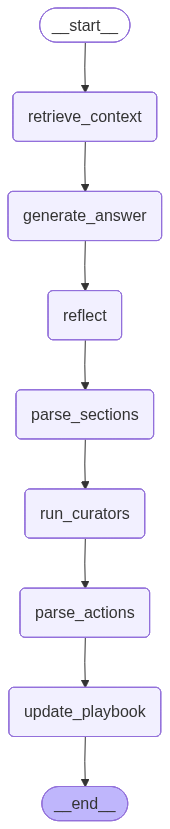

In [11]:
# Uncomment to visualize (requires graphviz)
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

## Run Single Question

In [12]:
# Initialize playbook
playbook = Playbook()

# Test with first question
question = queries[0]['question']
print(f"Question: {question}\n")

# Create initial state
initial_state = {
    "question": question,
    "playbook": playbook,
    "top_k": 10,
    "messages": []
}

# Run the graph
result = app.invoke(initial_state)

# Print messages
print("\nWorkflow execution:")
for msg in result["messages"]:
    print(msg)

print(f"\n{'='*80}")
print(f"Playbook State:")
print(f"  Bullets: {len(result['playbook'])}")
print(f"  User Profiles: {len(result['playbook'].user_profiles)}")
print(f"  Memories/Events: {len(result['playbook'].memories_events)}")
print(f"{'='*80}")

Question: When did Caroline go to the LGBTQ support group?


Workflow execution:
✓ Retrieved context (4555 chars)
✓ Retrieved context (4555 chars)
✓ Generated answer (1835 chars)
✓ Retrieved context (4555 chars)
✓ Retrieved context (4555 chars)
✓ Generated answer (1835 chars)
✓ Reflection complete
✓ Retrieved context (4555 chars)
✓ Retrieved context (4555 chars)
✓ Generated answer (1835 chars)
✓ Retrieved context (4555 chars)
✓ Retrieved context (4555 chars)
✓ Generated answer (1835 chars)
✓ Reflection complete
✓ Parsed sections: 5 insights, 5 profiles, 9 events
✓ Retrieved context (4555 chars)
✓ Retrieved context (4555 chars)
✓ Generated answer (1835 chars)
✓ Retrieved context (4555 chars)
✓ Retrieved context (4555 chars)
✓ Generated answer (1835 chars)
✓ Reflection complete
✓ Retrieved context (4555 chars)
✓ Retrieved context (4555 chars)
✓ Generated answer (1835 chars)
✓ Retrieved context (4555 chars)
✓ Retrieved context (4555 chars)
✓ Generated answer (1835 chars)
✓ Reflection comp

In [15]:
print(result['playbook'].format_for_prompt())

Knowledge Bullets:
0. [ID: f80f550b] **Direct Answer Extraction:** The playbook should prioritize direct answer extraction when questions are factual and explicitly stated in the conversation. This is the most common type of question in this context. (✓0/✗0)
1. [ID: 37a259df] **Handling Relative Time:** The playbook needs a mechanism to handle relative time references (e.g., "yesterday," "last week"). Ideally, it would track the conversation's timeline to resolve these references. If that's not possible, acknowledging the relative nature of the answer is important. (✓0/✗0)
2. [ID: 3de40834] **Contextual Awareness:** The playbook should be aware that the context is a series of conversational snippets, not a single document. This means information might be spread across multiple turns and require careful scanning. (✓0/✗0)
3. [ID: a42c165c] **Identifying Key Entities:** Recognizing entities like "LGBTQ support group," "activist group," and specific group names ("Connected LGBTQ Activists"

## Populate Codebook with Multiple Questions

In [16]:
def populate_codebook_langgraph(questions: List[str], initial_playbook: Playbook = None, top_k: int = 10) -> Playbook:
    """
    Main function to populate a playbook using LangGraph
    
    Args:
        questions: List of questions to process
        initial_playbook: Starting playbook (creates new one if None)
        top_k: Number of conversation chunks to retrieve
        
    Returns:
        Populated Playbook object
    """
    if initial_playbook is None:
        playbook = Playbook()
    else:
        playbook = initial_playbook
    
    print(f"{'='*80}")
    print(f"Starting Playbook Population with {len(questions)} questions")
    print(f"{'='*80}\n")
    
    for i, question in enumerate(questions, 1):
        print(f"\n{'='*80}")
        print(f"Processing Question {i}/{len(questions)}")
        print(f"{'='*80}")
        print(f"Q: {question}\n")
        
        # Create state for this question
        state = {
            "question": question,
            "playbook": playbook,
            "top_k": top_k,
            "messages": []
        }
        
        # Run the graph
        result = app.invoke(state)
        
        # Print workflow execution
        for msg in result["messages"]:
            print(msg)
        
        # Update playbook reference
        playbook = result["playbook"]
        
        print(f"\n📚 Playbook Status after Question {i}:")
        print(f"   - Bullets: {len(playbook)}")
        print(f"   - User Profiles: {len(playbook.user_profiles)}")
        print(f"   - Memories/Events: {len(playbook.memories_events)}")
    
    print(f"\n{'='*80}")
    print(f"Playbook Population Complete!")
    print(f"{'='*80}")
    print(f"Final Statistics:")
    print(f"   - Total Bullets: {len(playbook)}")
    print(f"   - Total User Profiles: {len(playbook.user_profiles)}")
    print(f"   - Total Memories/Events: {len(playbook.memories_events)}")
    print(f"{'='*80}\n")
    
    return playbook

In [17]:
# Get question list
question_list = [q['question'] for q in queries]
print(f"Total questions available: {len(question_list)}")
print("\nFirst 5 questions:")
for i, q in enumerate(question_list[:5], 1):
    print(f"{i}. {q}")

Total questions available: 199

First 5 questions:
1. When did Caroline go to the LGBTQ support group?
2. When did Melanie paint a sunrise?
3. What fields would Caroline be likely to pursue in her educaton?
4. What did Caroline research?
5. What is Caroline's identity?


In [18]:
# Run on first 3 questions
final_playbook = populate_codebook_langgraph(question_list[:3], top_k=10)

Starting Playbook Population with 3 questions


Processing Question 1/3
Q: When did Caroline go to the LGBTQ support group?

✓ Retrieved context (4555 chars)
✓ Retrieved context (4555 chars)
✓ Generated answer (2380 chars)
✓ Retrieved context (4555 chars)
✓ Retrieved context (4555 chars)
✓ Generated answer (2380 chars)
✓ Reflection complete
✓ Retrieved context (4555 chars)
✓ Retrieved context (4555 chars)
✓ Generated answer (2380 chars)
✓ Retrieved context (4555 chars)
✓ Retrieved context (4555 chars)
✓ Generated answer (2380 chars)
✓ Reflection complete
✓ Parsed sections: 7 insights, 6 profiles, 8 events
✓ Retrieved context (4555 chars)
✓ Retrieved context (4555 chars)
✓ Generated answer (2380 chars)
✓ Retrieved context (4555 chars)
✓ Retrieved context (4555 chars)
✓ Generated answer (2380 chars)
✓ Reflection complete
✓ Retrieved context (4555 chars)
✓ Retrieved context (4555 chars)
✓ Generated answer (2380 chars)
✓ Retrieved context (4555 chars)
✓ Retrieved context (4555 chars)
✓ Gen

## Display Playbook Summary

In [19]:
def display_playbook_summary(playbook: Playbook):
    """Display a formatted summary of the playbook contents"""
    print(f"\n{'='*80}")
    print("PLAYBOOK SUMMARY")
    print(f"{'='*80}\n")
    
    # Display bullets
    if playbook.bullets:
        print(f"📌 KNOWLEDGE BULLETS ({len(playbook.bullets)}):")
        print("-" * 80)
        for i, bullet in enumerate(playbook.bullets):
            print(f"{i}. {bullet.content}")
            print(f"   [✓{bullet.helpful_count}/✗{bullet.harmful_count}]")
            print()
    else:
        print("📌 KNOWLEDGE BULLETS: None\n")
    
    # Display user profiles
    if playbook.user_profiles:
        print(f"👤 USER PROFILES ({len(playbook.user_profiles)}):")
        print("-" * 80)
        for user_id, profile in playbook.user_profiles.items():
            print(f"User: {user_id}")
            for key, value in profile.items():
                print(f"  - {key}: {value}")
            print()
    else:
        print("👤 USER PROFILES: None\n")
    
    # Display memories/events
    if playbook.memories_events:
        print(f"🎯 MEMORIES & EVENTS ({len(playbook.memories_events)}):")
        print("-" * 80)
        for i, event in enumerate(playbook.memories_events):
            print(f"{i}. {event}")
            print()
    else:
        print("🎯 MEMORIES & EVENTS: None\n")
    
    print(f"{'='*80}\n")

# Display the final playbook
display_playbook_summary(final_playbook)


PLAYBOOK SUMMARY

📌 KNOWLEDGE BULLETS (9):
--------------------------------------------------------------------------------
0. **Successful Factual Recall:** The response successfully identified the relevant information about Caroline attending the LGBTQ support group. The strategy of scanning the conversation for keywords ("LGBTQ support group," "yesterday") was effective.
   [✓0/✗0]

1. **Handling Relative Time:** The response correctly recognized "yesterday" as a relative term and acknowledged the need for a temporal anchor ("last Tuesday") to understand the timeframe.
   [✓0/✗0]

2. **Contextual Awareness:** The response demonstrated an understanding of the conversational flow and the importance of considering the preceding turns to interpret the meaning of "yesterday."
   [✓0/✗0]

3. **Importance of Temporal Markers:** The conversation frequently uses temporal markers (e.g., "yesterday," "last Tuesday," "last week") which are crucial for understanding the sequence of events.
   [